##### imports 

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

##### data

In [3]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1002,A1015 and E1034 have 4 or fewer data points
df = df[~((df['ID'] == 'A1009') & (df['sum_tumor_lengths'] == 10))] 
#remove the last point (10mm)as it is a single lymph node 5 days after previous scan -add to previous instead)
# Add 10 to the value at row 68 and column 1 as dates should be combined
df.iloc[68, 1] = df.iloc[68, 1] + 10
df.iloc[68,2] = df.iloc[68,2] + 167 


df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1003,A1015 and E1034 have 4 or fewer data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

##### functions 

In [128]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops-data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


In [63]:
print(max(df.iloc[:, 1]))

116.0


##### fitting model

In [153]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

# fitting patient data to equations (r,Kmax,lamda,spop,rpop)
    max_value = max(data[0], data[-1])

    # these are pretty good - don't delete 
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    #trying these
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    opt_result_log = minimize(cost_func_gompertizian, init_params, 
                              args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 


Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


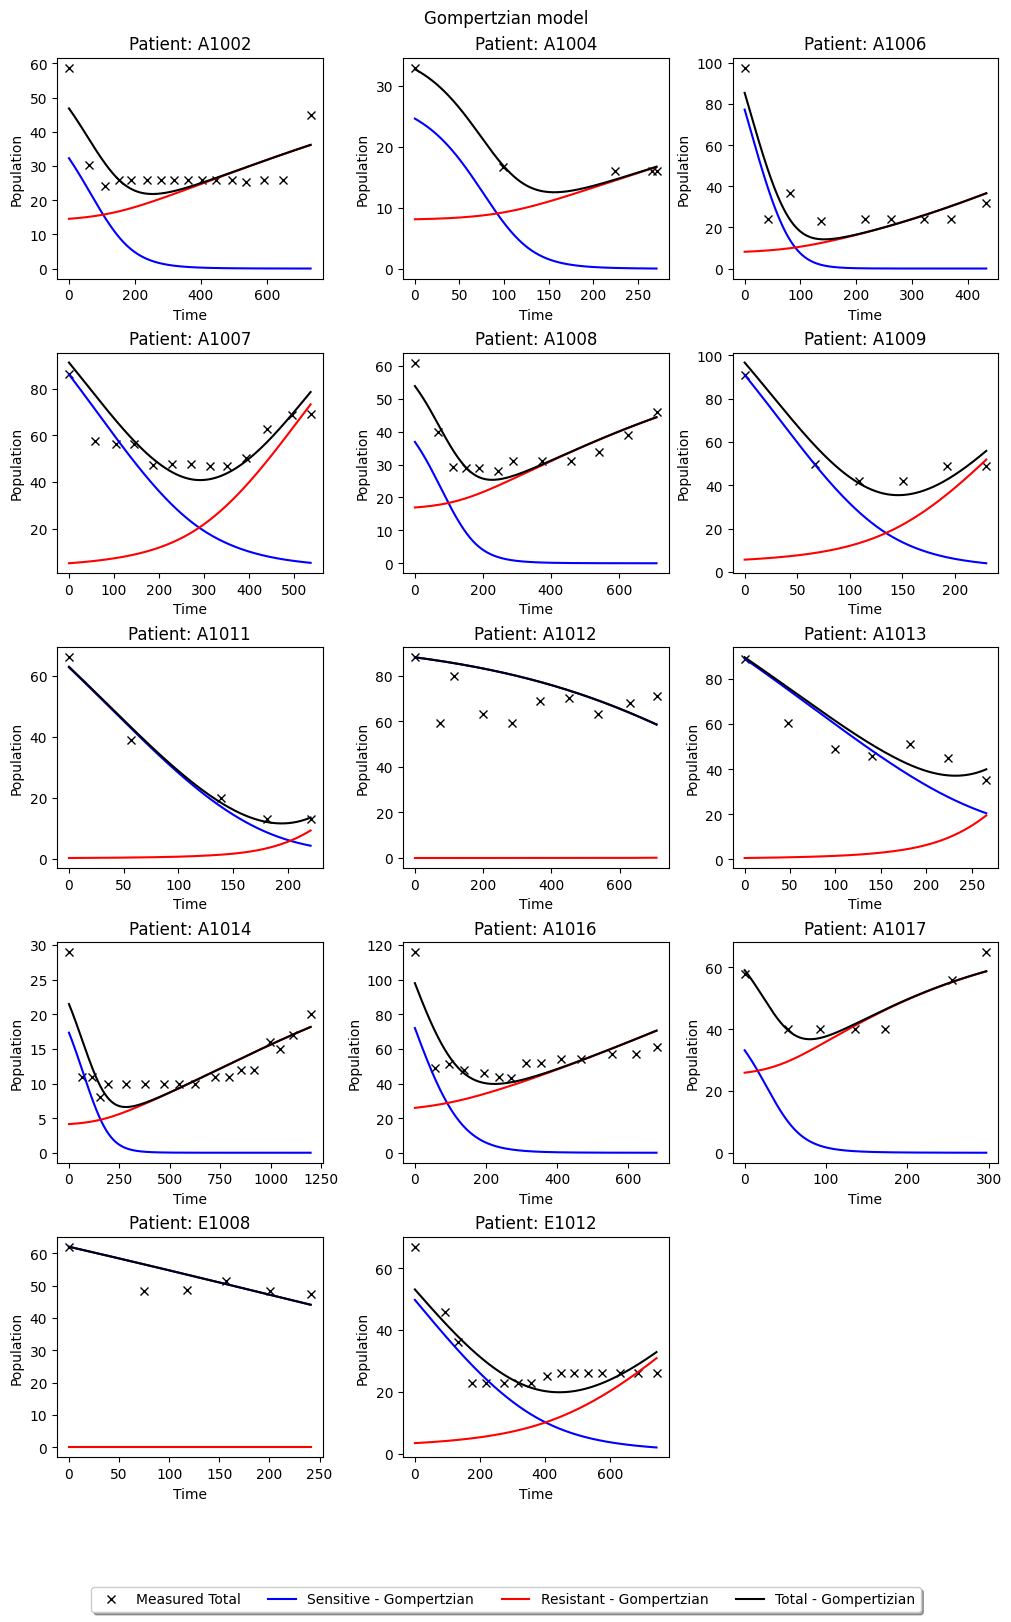

In [154]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [145]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.001521,64.570000,10.000000,32.270030,14.549193,30.499897
A1004,0.003651,36.300000,9.999849,24.654014,8.123389,0.578391
A1006,0.001702,191.839419,9.885875,77.272520,8.148197,122.330237
A1007,0.004420,172.400000,2.041639,86.200000,5.122213,57.330244
A1008,0.002008,67.100000,10.000000,36.892883,16.960408,12.417544
A1009,0.007627,177.927957,2.408934,91.000000,5.704737,38.419450
A1011,0.010437,132.000000,1.705477,62.691120,0.204373,5.903949
A1012,0.022189,96.800000,1.106056,87.988051,0.002576,191.932047
A1013,0.010979,175.842616,1.425308,89.000000,0.614391,84.498770
A1014,0.001201,31.900000,10.000000,17.344367,4.133560,7.437065


##### Gompertzian with differential evolution for parameters

In [157]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_gompertizian, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16


C:\Users\lstocker\AppData\Local\Temp\ipykernel_31460\3376385897.py:32: RuntimeWarning: overflow encountered in square
  sumsq_error = np.sum((sum_pops-data)**2)


Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


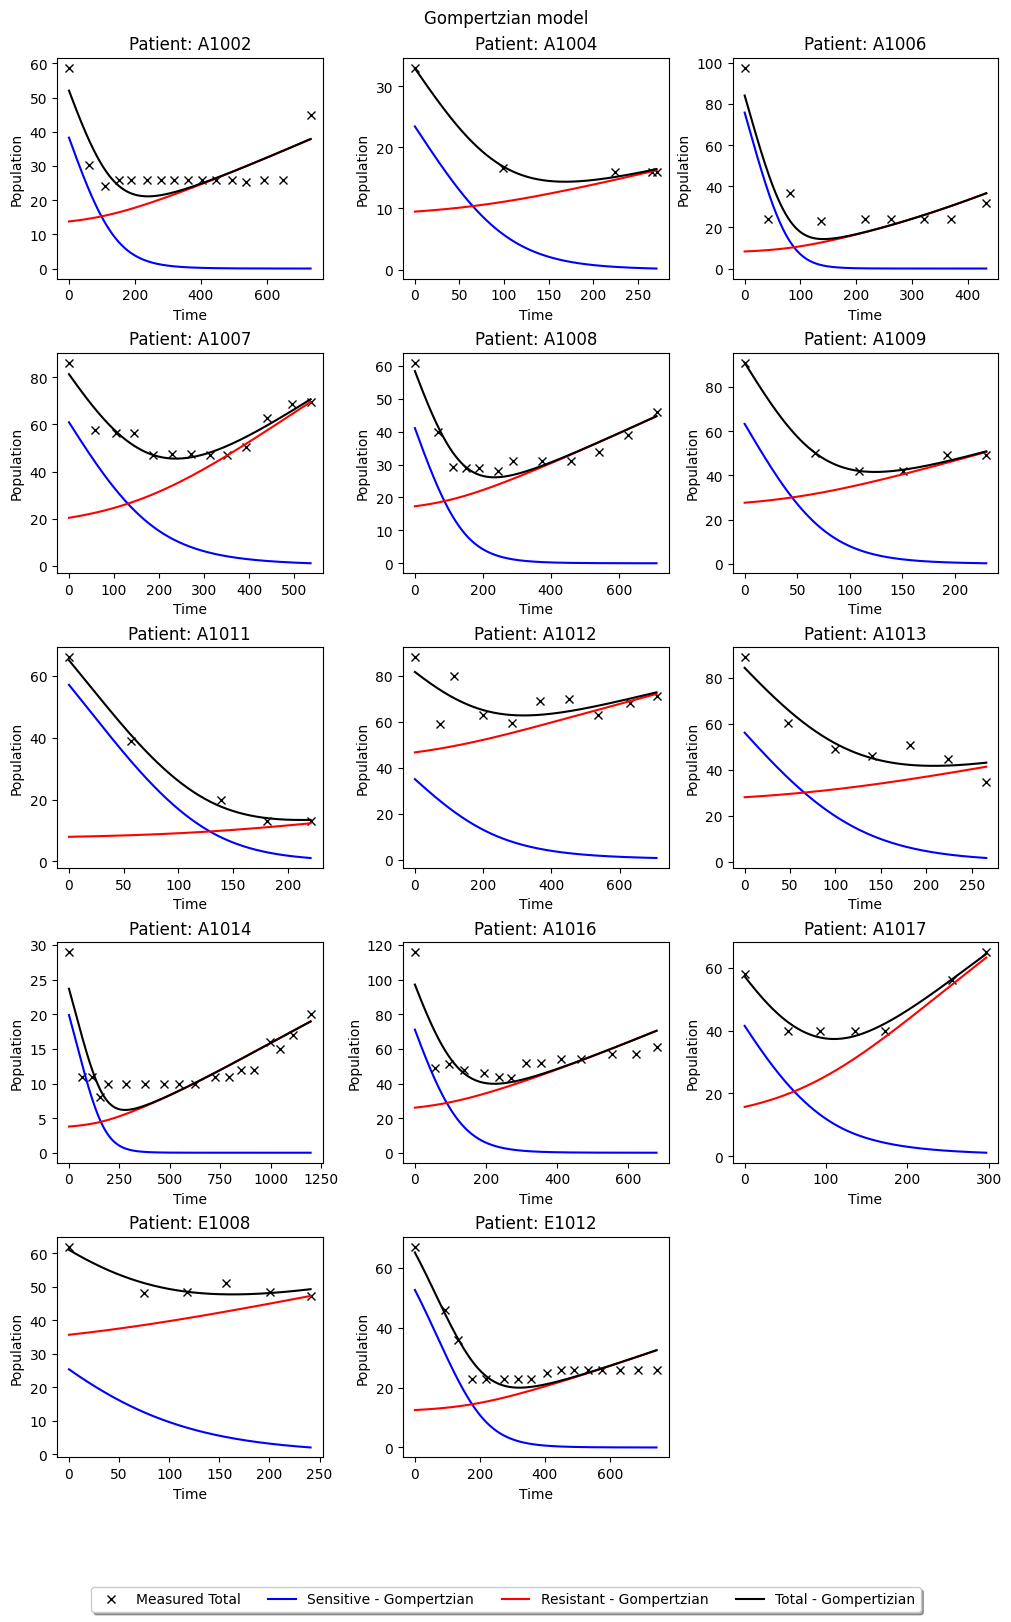

In [158]:
  
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [159]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.001000,112.850450,9.997387,38.264948,13.769586,24.518749
A1004,0.001509,65.991894,10.000000,23.414851,9.491374,0.208430
A1006,0.001668,195.060627,10.000000,75.833946,8.292960,120.409178
A1007,0.002022,172.094640,4.252103,60.872510,20.391896,15.032669
A1008,0.001049,121.614140,9.997251,41.079788,17.318846,6.227630
A1009,0.002053,181.268717,9.994222,63.279446,27.636099,1.721016
A1011,0.001199,132.000000,10.000000,57.088474,7.951802,2.082812
A1012,0.001000,124.859004,10.000000,34.989946,46.629577,45.956819
A1013,0.001165,176.991112,9.975635,56.235521,28.172559,30.385527
A1014,0.001000,43.014756,9.991000,19.901635,3.782436,6.418666


##### Gompertzian DE with 1/2 dose 

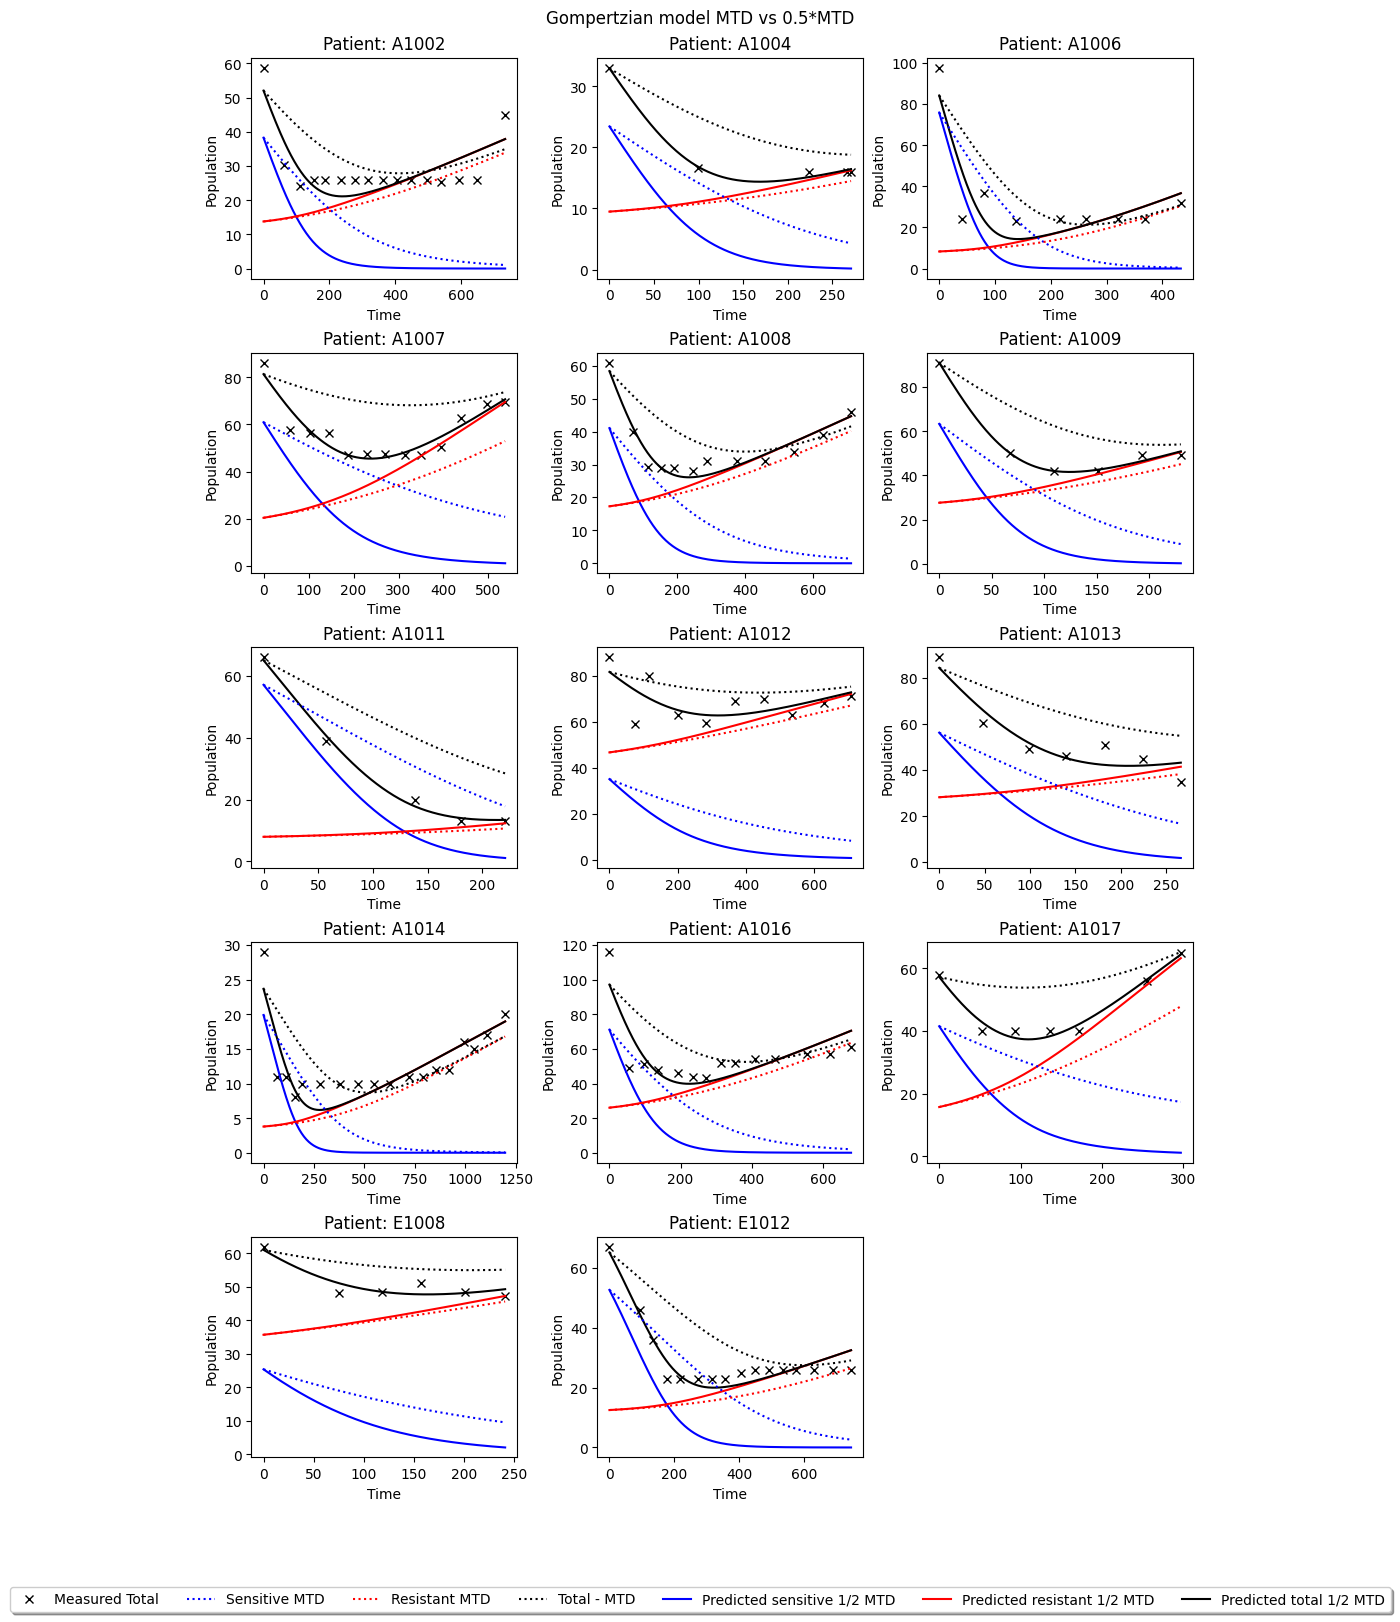

In [163]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True, max_step = 1e-4,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    #plot data
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### Extended predictions 1/2 MTD vs MTD

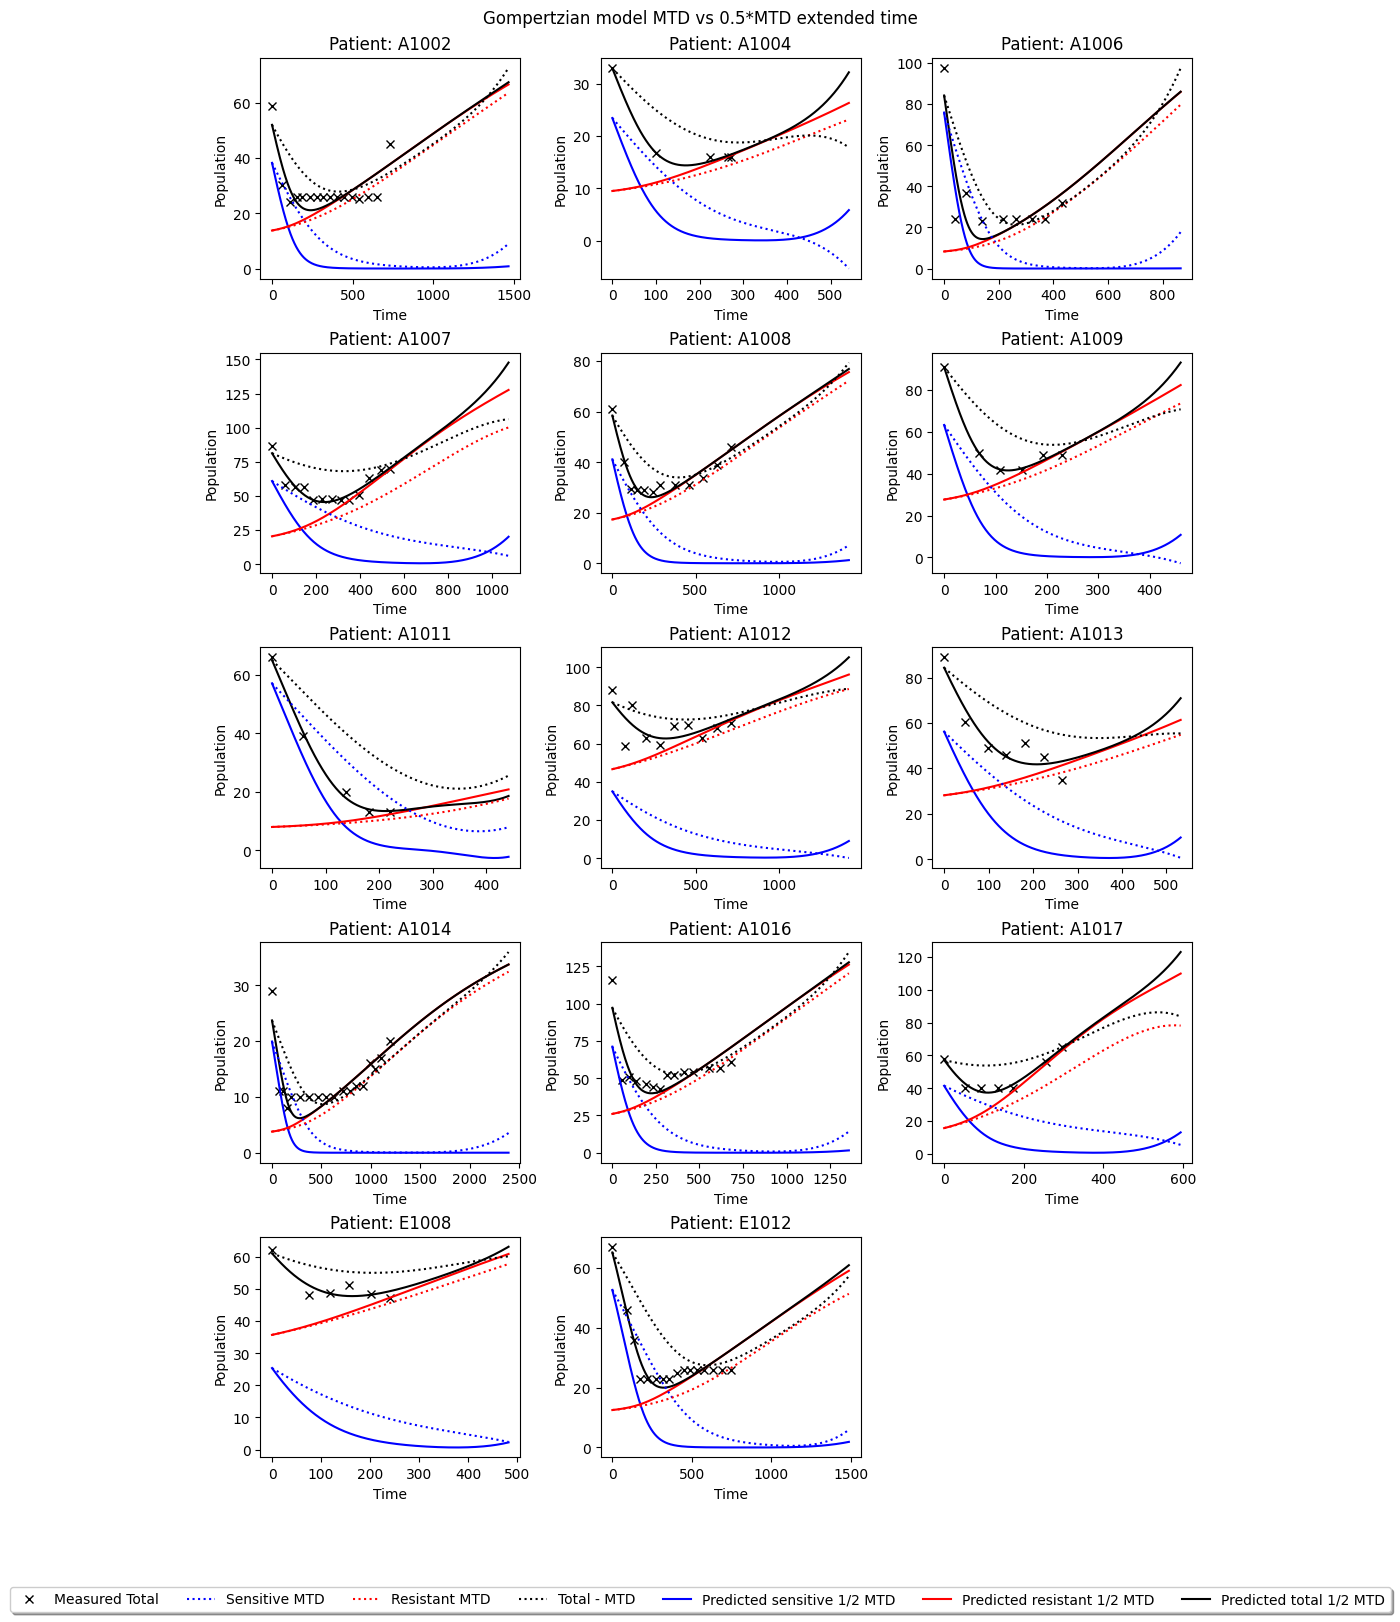

In [170]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, 2*days[-1], 500)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD extended time')  
plt.show()